# Machine Learning and Deep Learning (KAN-CDSCO2004U)

## Authors:
- Maxwell bernard, Student ID: 175870
- Tim Laurin Roessling, Student ID: 175881
- Johan Henri Schommartz, Student ID: 175871

# Import libraries

In [1]:
# Data Processing & Evaluation
import numpy as np
import pandas as pd
from sklearn.utils import shuffle, compute_class_weight
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, GridSearchCV
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
)
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA

# Machine Learning
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import StratifiedKFold

# Deep Learning
import tensorflow as tf
import visualkeras
from tensorflow import keras
from tensorflow.keras import layers, Model, Sequential
from tensorflow.keras.layers import (
    Dense,
    Flatten,
    Conv2D,
    MaxPooling2D,
    Dropout,
    BatchNormalization,
)
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy, BinaryCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.regularizers import l2


# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Image and File Handling
from PIL import Image
import imagehash
from pathlib import Path
import os
import glob
import shutil

# Miscellaneous
import random
import warnings
import time
from collections import defaultdict
import kagglehub

# Configuration
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
pd.options.mode.chained_assignment = None
pd.options.display.max_columns = None
pd.options.display.width = None
pd.set_option("max_colwidth", 400)
tf.config.run_functions_eagerly(True)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

# Download Kaggle Dataset
We created a datset comprising of 5 kaggle datasets and uploaded it to Kaggle.

The dataset is available at [this link](https://www.kaggle.com/datasets/maxwellbernard/brain-tumor-mri-multi-class-dataset/data). 
 
The dataset is downloaded from Kaggle via its API to then start the data preprocessing.

In [5]:
path = kagglehub.dataset_download("maxwellbernard/brain-tumor-mri-multi-class-dataset")
base_dir = os.path.join(path, "multi_class_dataset")
base_dir = Path(base_dir)
classes = ["glioma", "healthy", "meningioma", "pituitary"]

100%|██████████| 471M/471M [01:22<00:00, 5.97MB/s] 

Extracting files...


# EDA

## Raw Data Class Distribution

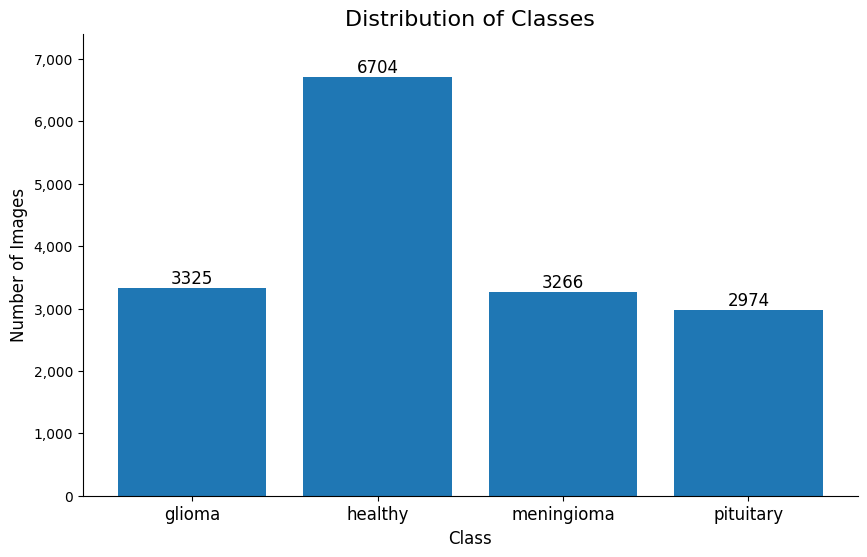

In [ ]:
def plot_class_distribution_raw(base_dir, classes):
    class_counts = []
    for class_name in classes:
        class_dir = os.path.join(base_dir, class_name)
        count = len(os.listdir(class_dir))
        class_counts.append(count)

    plt.figure(figsize=(10, 6))
    plt.bar(classes, class_counts)
    plt.xlabel("Class", fontsize=12)
    plt.ylabel("Number of Images", fontsize=12)
    plt.gca().get_yaxis().set_major_formatter(
        plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x)))
    )
    plt.title("Distribution of Classes", fontsize=16)
    for i, count in enumerate(class_counts):
        plt.text(i, count + 10, str(count), ha="center", va="bottom", fontsize=12)
    plt.ylim(0, max(class_counts) + 700)
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)
    plt.xticks(fontsize=12)


plot_class_distribution_raw(base_dir, classes)
plt.savefig("class_distribution_raw.png", dpi=300, bbox_inches="tight")

## Find uniqe file types

In [18]:
file_types = set()
for data in classes:
    dataset_path = base_dir / data
    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            file_types.add(file.split(".")[-1])
print("Unique file types in the dataset:", file_types)

Unique file types in the dataset: {'jpg', 'jpeg', 'png'}


## Inspect Raw Image sizes

In [19]:
def image_size_stats(base_dir: str, classes: list) -> None:
    """Prints image size statistics for the given directory and classes."""
    size_counts = defaultdict(int)

    for data in classes:
        dataset_path = base_dir / data
        for root, dirs, files in os.walk(dataset_path):
            for file in files:
                if file.endswith(tuple(file_types)):
                    image_path = os.path.join(root, file)
                    try:
                        with Image.open(image_path) as img:
                            size_counts[img.size] += 1
                    except Exception as e:
                        print(f"Error processing {image_path}: {e}")

    total_images = sum(size_counts.values())
    sorted_sizes = sorted(size_counts.items(), key=lambda x: x[1], reverse=True)

    print(f"Total images: {total_images}\n")
    for size, count in sorted_sizes:
        percentage = (count / total_images) * 100
        print(f"{size[0]} x {size[1]} pixels - {count} images ({percentage:.1f}% of dataset)")


image_size_stats(base_dir, classes)

Total images: 16269

512 x 512 pixels - 10882 images (66.9% of dataset)
256 x 256 pixels - 1509 images (9.3% of dataset)
630 x 630 pixels - 504 images (3.1% of dataset)
224 x 224 pixels - 438 images (2.7% of dataset)
225 x 225 pixels - 350 images (2.2% of dataset)
236 x 236 pixels - 86 images (0.5% of dataset)
400 x 539 pixels - 64 images (0.4% of dataset)
201 x 251 pixels - 62 images (0.4% of dataset)
442 x 442 pixels - 54 images (0.3% of dataset)
228 x 221 pixels - 53 images (0.3% of dataset)
232 x 217 pixels - 50 images (0.3% of dataset)
300 x 168 pixels - 49 images (0.3% of dataset)
200 x 252 pixels - 45 images (0.3% of dataset)
150 x 198 pixels - 44 images (0.3% of dataset)
549 x 630 pixels - 44 images (0.3% of dataset)
428 x 417 pixels - 42 images (0.3% of dataset)
227 x 222 pixels - 39 images (0.2% of dataset)
173 x 201 pixels - 36 images (0.2% of dataset)
206 x 244 pixels - 35 images (0.2% of dataset)
192 x 192 pixels - 31 images (0.2% of dataset)
215 x 234 pixels - 30 images (

We can see that the images are of many different sizes. We will will resize them to a common size of 224 x 224 pixels that is a large enough size to capture the details of the images whilst being computationally efficient.

### Plot Resolution by Class

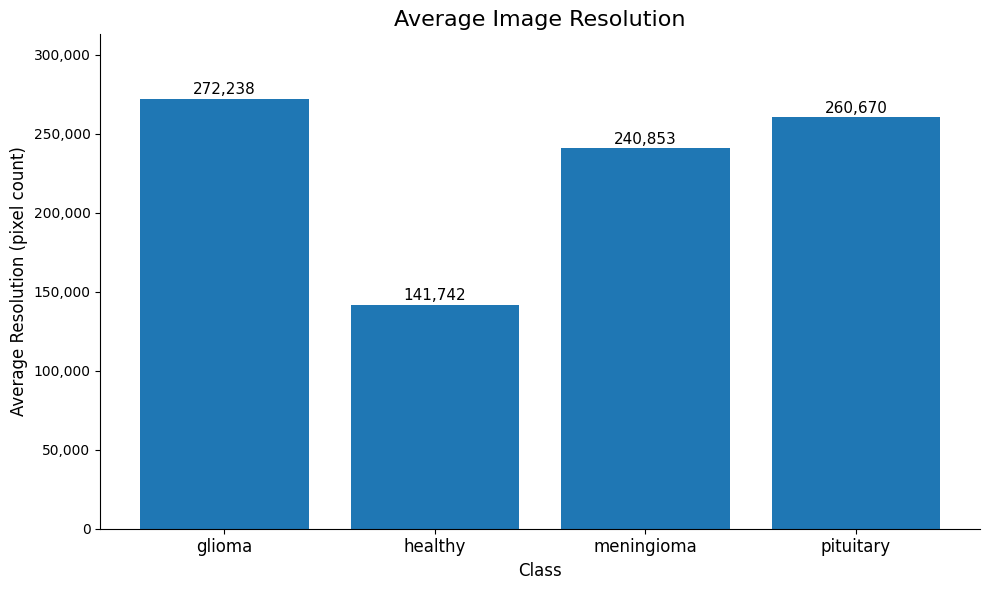

In [20]:
def plot_class_vs_avg_resolution(base_dir, classes):
    avg_resolutions = []
    avg_pixel_counts = []

    for class_name in classes:
        class_dir = os.path.join(base_dir, class_name)
        resolutions = []
        for img_file in os.listdir(class_dir):
            if img_file.lower().endswith((".jpg", ".jpeg", ".png")):  # safer check
                img_path = os.path.join(class_dir, img_file)
                with Image.open(img_path) as img:
                    resolutions.append(img.size)
        avg_resolution = np.mean(resolutions, axis=0)
        avg_resolutions.append(avg_resolution)
        avg_pixel_counts.append(avg_resolution[0] * avg_resolution[1])

    plt.figure(figsize=(10, 6))
    bars = plt.bar(classes, avg_pixel_counts)
    plt.xlabel("Class", fontsize=12)
    plt.ylabel("Average Resolution (pixel count)", fontsize=12)
    plt.title("Average Image Resolution", fontsize=16)
    plt.xticks(fontsize=12)
    plt.gca().get_yaxis().set_major_formatter(
        plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x)))
    )
    for i, count in enumerate(avg_pixel_counts):
        plt.text(i, count + 1000, f"{int(count):,}", ha="center", va="bottom", fontsize=11)

    plt.ylim(0, max(avg_pixel_counts) * 1.15)
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)
    plt.tight_layout()
    plt.savefig("avg_resolution_by_class.png", dpi=300, bbox_inches="tight")
    plt.show()


plot_class_vs_avg_resolution(base_dir, classes)

# Data Cleaning
In this section we will resize the images to a common size of 224 x 224 pixels and then check and remove duplicate images using the imagehash library.

## Resize Images
Center crop and resize the images, saving them as jpg files. Quality size of 95 is chosen to keep the file size small whilst maintaining a good quality image. It is standard practice and is used by TensorFlow/Keras in their preprocessing functions.

In [ ]:
def center_crop(img: Image.Image) -> Image.Image:
    """Center crop image to square dimensions."""
    width, height = img.size
    min_dim = min(width, height)
    left = (width - min_dim) / 2
    top = (height - min_dim) / 2
    right = (width + min_dim) / 2
    bottom = (height + min_dim) / 2
    return img.crop((left, top, right, bottom))


def process_image(img_path: str) -> None:
    """Process and overwrite a single image, converting to .jpg extension."""
    try:
        img_path = Path(img_path)
        with Image.open(img_path) as img:
            img_cropped = center_crop(img)
            img_resized = img_cropped.resize((224, 224), Image.LANCZOS)
            img_grayscale = img_resized
            new_path = img_path.with_suffix(".jpg")
            img_grayscale.save(new_path, "JPEG", quality=95, optimize=True)
            if new_path != img_path:
                img_path.unlink()
    except Exception as e:
        print(f"Error processing {img_path}: {e}")


def process_all_images(input_dir: str) -> None:
    """Process all images in-place (overwrite originals)."""
    input_path = Path(input_dir)

    image_count = 0
    for img_file in input_path.glob("*"):
        if img_file.suffix.lower() in (".jpg", ".jpeg", ".png"):
            process_image(img_file)
            image_count += 1
    print(f"Processed {image_count} images in {input_path.name}")


for class_name in classes:
    class_dir = base_dir / class_name
    process_all_images(class_dir)

image_size_stats(base_dir, classes)

Processed 3325 images in glioma
Processed 6704 images in healthy
Processed 3266 images in meningioma
Processed 2974 images in pituitary
Total images: 16259

224 x 224 pixels - 16259 images (100.0% of dataset)


## Removing Duplicate Images

### Identify Duplicate Images

This method detects near-duplicate images using perceptual hashing (pHash), which captures the image's visual structure rather than relying on exact pixel data.

We used `phash` instead of exact byte comparison or `hash` functions because the images had different resolutions (e.g., 512×512 vs 256×256), meaning their raw bytes would differ even if they looked visually identical. `phash` is robust to such variations, enabling us to detect duplicates based on appearance, not file content.

We chose a threshold of 2 for the Hamming distance to ensure that only nearly identical images are grouped as duplicates, not just visually similar ones. In the context of brain MRI scans, this strict threshold helps avoid grouping distinct scans from different patients, preserving the clinical relevance of the dataset.

In [ ]:
def find_image_duplicates_phash(image_paths: list[str], threshold=2) -> list[list[str]]:
    """
    Finds duplicate images using perceptual hash (pHash).
    """
    print(f"Scanning {len(image_paths)} images...")

    image_hashes = []
    for path in image_paths:
        try:
            with Image.open(path) as img:
                hash_val = imagehash.phash(img)
                image_hashes.append((path, hash_val))
        except Exception as e:
            print(f"Error reading image {path}: {e}")

    # Compare hashes and group duplicates
    grouped = []
    seen = set()

    for i, (path1, hash1) in enumerate(image_hashes):
        if path1 in seen:
            continue
        group = [path1]
        for j in range(i + 1, len(image_hashes)):
            path2, hash2 = image_hashes[j]
            if path2 not in seen and hash1 - hash2 <= threshold:
                group.append(path2)
                seen.add(path2)
        if len(group) > 1:
            seen.update(group)
            grouped.append(group)

    return grouped

### Summarize Duplicate Images Found

In [23]:
from glob import glob


def total_images_in_folder(folder_path):
    """Returns the total number of images in a folder."""
    return len([f for f in os.listdir(folder_path) if f.lower().endswith((".jpg"))])


total_images = 0
all_image_paths = []
for cls in classes:
    class_path = base_dir / cls
    all_image_paths += glob(str(class_path / "*.jpg"))
    total_images += total_images_in_folder(class_path)

duplicates = find_image_duplicates_phash(all_image_paths)

total_duplicates = sum(len(group) for group in duplicates)
total_duplicate_groups = len(duplicates)
to_be_deleted = total_duplicates - total_duplicate_groups
total_unique_images = total_images - to_be_deleted
percentage_duplicates = (to_be_deleted / total_images) * 100

print("Total number of duplicated groups:", total_duplicates)
print("Total number of unique images within duplicated groups:", total_duplicate_groups)
print("Number of images to be deleted:", to_be_deleted)
print("Total number of unique images overall:", total_unique_images)
print(f"Percentage of overall images which are duplicates: {percentage_duplicates:.2f}%")

Scanning 16259 images...
Total number of duplicated groups: 8496
Total number of unique images within duplicated groups: 3257
Number of images to be deleted: 5239
Total number of unique images overall: 11020
Percentage of overall images which are duplicates: 32.22%


 ## Visual Examples of Duplicates
 
The following images are examples of duplicates detected by the perceptual hashing method.

Visualizing duplicate group: ['Rajarshi_Mandal_healthy_3679.jpg', 'Rajarshi_Mandal_healthy_3202.jpg', 'Rajarshi_Mandal_healthy_2127.jpg', 'Rajarshi_Mandal_healthy_2975.jpg', 'Rajarshi_Mandal_healthy_3475.jpg']


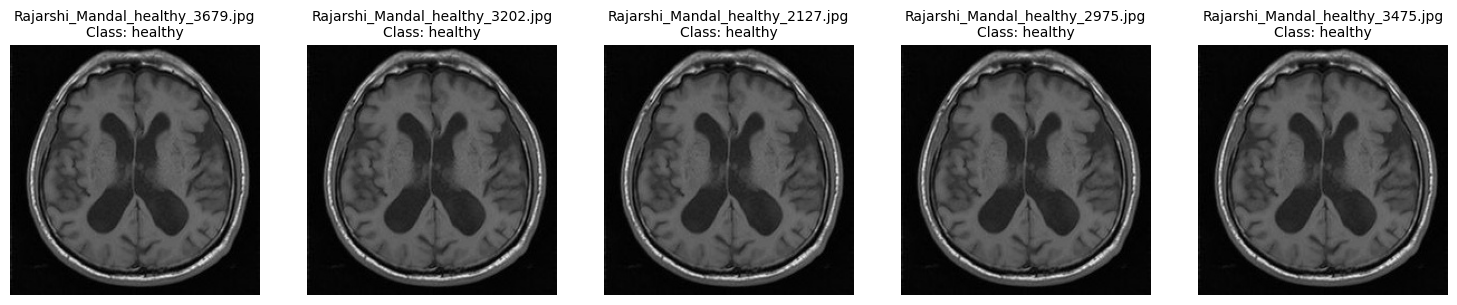

Visualizing duplicate group: ['Hossein_Hashemi_pituitary_138.jpg', 'Orvile_pituitary_53.jpg', 'Rajarshi_Mandal_pituitary_447.jpg']


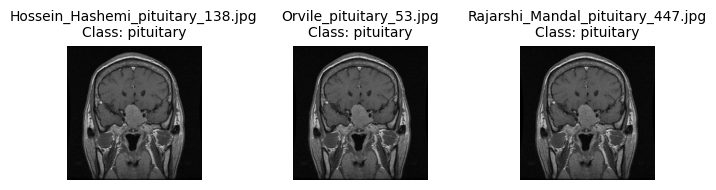

In [ ]:
def visualize_duplicate_group(duplicates: list, group_index: int, figsize=(15, 3)) -> None:
    """Visualize a group of duplicate images by index, including file name, class name, and dataset name."""
    if group_index >= len(duplicates):
        print(f"Group index {group_index} is out of range.")
        return

    duplicate_group = duplicates[group_index]
    print("Visualizing duplicate group:", [os.path.basename(p) for p in duplicate_group])

    plt.figure(figsize=figsize)

    for i, path in enumerate(duplicate_group):
        img = Image.open(path)
        class_name = os.path.basename(os.path.dirname(path))
        file_name = os.path.basename(path)

        plt.subplot(1, len(duplicate_group), i + 1)
        plt.imshow(np.array(img), cmap="gray")
        plt.title(f"{file_name}\nClass: {class_name}", fontsize=10)
        plt.axis("off")

    plt.tight_layout()
    plt.show()


visualize_duplicate_group(duplicates, group_index=750, figsize=(15, 3))
visualize_duplicate_group(duplicates, group_index=2511, figsize=(7, 2))

## Remove Duplicate Images

In [30]:
for group in duplicates:
    kept_image = group[0]  # Keep the first image, delete the rest
    for duplicate in group[1:]:
        try:
            os.remove(duplicate)
        except Exception as e:
            print(f"Error deleting {os.path.basename(duplicate)}: {e}")

deleted_count = sum(len(group) - 1 for group in duplicates)
print(f"Total number of images deleted: {deleted_count}")
print("Duplicate removal completed.")

for cls in classes:
    class_path = base_dir / cls
    print(f"Total number of images in {cls} class: {total_images_in_folder(class_path)}")

Total number of images deleted: 5239
Duplicate removal completed.
Total number of images in glioma class: 2668
Total number of images in healthy class: 4629
Total number of images in meningioma class: 2048
Total number of images in pituitary class: 1675


# Data Pipeline
This section outlines the data pipeline for loading, splitting, preprocessing and augmenting the dataset.

The pipeline is designed to be efficient and flexible, allowing for easy adjustments to the preprocessing steps as needed.

### Split Data 

In [13]:
image_paths = []
labels = []

for class_name in classes:
    class_path = os.path.join(base_dir, class_name)
    image_files = [
        f
        for f in os.listdir(class_path)
        if os.path.isfile(os.path.join(class_path, f)) and not f.startswith(".")
    ]

    for img_file in image_files:
        img_path = os.path.join(class_path, img_file)
        image_paths.append(img_path)
        labels.append(class_name)

df = pd.DataFrame({"filename": image_paths, "class": labels})

# split the data into train, validation, and test sets
df_trainval, test_df = train_test_split(df, test_size=0.15, stratify=df["class"], random_state=42)
val_relative_size = 0.15 / (1 - 0.15)  # 0.15 / 0.85 ≈ 0.176
sss = StratifiedShuffleSplit(n_splits=1, test_size=val_relative_size, random_state=42)
for train_index, val_index in sss.split(df_trainval, df_trainval["class"]):
    train_df = df_trainval.iloc[train_index]
    val_df = df_trainval.iloc[val_index]

print(f"Train size: {len(train_df)}")
print(f"Validation size: {len(val_df)}")
print(f"Test size: {len(test_df)}")

# compute class weights to handle class imbalance
class_weights = compute_class_weight(
    "balanced", classes=np.unique(train_df["class"]), y=train_df["class"]
)
class_weights_dict = dict(enumerate(class_weights))
print("Class weights:", class_weights_dict)

class_names = train_df["class"].unique()

Train size: 7714
Validation size: 1653
Test size: 1653
Class weights: {0: 1.032387580299786, 1: 0.595216049382716, 2: 1.344839609483961, 3: 1.6454778156996588}


### Image Data Generators & Augmentation

In [14]:
def create_generator(df, datagen, shuffle=True):
    return datagen.flow_from_dataframe(
        dataframe=df,
        x_col="filename",
        y_col="class",
        target_size=(224, 224),
        color_mode="grayscale",
        class_mode="categorical",
        batch_size=32,
        shuffle=shuffle,
        seed=42,
    )


# Instantiate generators with augmentation for training data
train_datagen_aug = ImageDataGenerator(
    rescale=1.0 / 255,
    horizontal_flip=True,
    zoom_range=0.05,
    width_shift_range=0.02,
    height_shift_range=0.02,
    rotation_range=5,
    brightness_range=[0.9, 1.1],
    fill_mode="nearest",
)

datagen = ImageDataGenerator(rescale=1.0 / 255)
train_generator_aug = create_generator(train_df, train_datagen_aug, shuffle=True)
val_generator = create_generator(val_df, datagen, shuffle=False)
test_generator = create_generator(test_df, datagen, shuffle=False)

Found 7714 validated image filenames belonging to 4 classes.
Found 1653 validated image filenames belonging to 4 classes.
Found 1653 validated image filenames belonging to 4 classes.


# SVM Model

In [ ]:
def load_and_flatten_images(generator):
    generator.reset()
    x, y = [], []
    for batch_x, batch_y in generator:
        x.append(batch_x.reshape(len(batch_x), -1))
        y.append(np.argmax(batch_y, axis=1))
        if len(np.concatenate(x)) >= generator.n:
            break
    images = np.concatenate(x)[: generator.n]
    labels = np.concatenate(y)[: generator.n]

    return images, labels


train_generator = create_generator(train_df, train_datagen_aug, shuffle=False)
val_generator = create_generator(val_df, datagen, shuffle=False)
test_generator = create_generator(test_df, datagen, shuffle=False)
x_train, y_train = load_and_flatten_images(train_generator)
x_val, y_val = load_and_flatten_images(val_generator)
x_test, y_test = load_and_flatten_images(test_generator)

Found 7711 validated image filenames belonging to 4 classes.
Found 1653 validated image filenames belonging to 4 classes.
Found 1653 validated image filenames belonging to 4 classes.


## Run SVM Model

In [ ]:
class_names = list(train_generator.class_indices.keys())
pca = PCA(whiten=True, random_state=42)
svc = SVC(kernel="rbf", max_iter=10000, random_state=42, class_weight="balanced")
pipeline = make_pipeline(pca, svc)
param_grid = {
    "pca__n_components": [100, 150, 200],
    "svc__C": [0.05, 0.01, 0.1],
}

start_time = time.time()
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring="f1_macro",
    verbose=5,
    n_jobs=8,
    return_train_score=True,
)

print("Starting GridSearchCV with SVC(kernal='rbf') and PCA...")
grid_search.fit(x_train, y_train)
best_model = grid_search.best_estimator_
fitted_pca = best_model.named_steps["pca"]
explained_variance = fitted_pca.explained_variance_ratio_.sum() * 100
print(
    f"PCA retained {fitted_pca.n_components_} components explaining {explained_variance:.2f}% of the variance."
)

end_time = time.time()
SVM_time = end_time - start_time
SVM_v1_time_minutes = SVM_time / 60
print(f"SVM completed in {SVM_v1_time_minutes:.1f} minutes.")

Starting GridSearchCV with SVC(kernal='rbf') and PCA...
Fitting 5 folds for each of 9 candidates, totalling 45 fits
PCA retained 100 components explaining 69.76% of the variance.
SVM completed in 17.2 minutes.


## Evaluate SVM Model

In [18]:
print("Best parameters from GridSearchCV:")
print(grid_search.best_params_)

Best parameters from GridSearchCV:
{'pca__n_components': 100, 'svc__C': 0.1}


In [ ]:
def evaluate_model(model, X, y, name=""):
    preds = model.predict(X)
    acc = accuracy_score(y, preds)
    print(f"{name} accuracy: {acc:.4f}")
    print(classification_report(y, preds, target_names=class_names))
    return preds, acc


y_train_pred, train_acc = evaluate_model(best_model, x_train, y_train, "Training")
y_val_pred, val_acc = evaluate_model(best_model, x_val, y_val, "Validation")
y_test_pred, test_acc = evaluate_model(best_model, x_test, y_test, "Test")

Training accuracy: 0.6929
              precision    recall  f1-score   support

      glioma       0.71      0.60      0.65      1865
     healthy       0.86      0.67      0.76      3239
  meningioma       0.45      0.69      0.54      1434
   pituitary       0.76      0.90      0.83      1173

    accuracy                           0.69      7711
   macro avg       0.70      0.72      0.69      7711
weighted avg       0.73      0.69      0.70      7711

Validation accuracy: 0.6927
              precision    recall  f1-score   support

      glioma       0.75      0.60      0.66       400
     healthy       0.89      0.70      0.78       694
  meningioma       0.41      0.60      0.49       308
   pituitary       0.69      0.93      0.79       251

    accuracy                           0.69      1653
   macro avg       0.69      0.71      0.68      1653
weighted avg       0.74      0.69      0.70      1653

Test accuracy: 0.6854
              precision    recall  f1-score   support


# CNN Models

## CNN Shallow Model

In [45]:
opt = Adam(learning_rate=0.0001)
cce = CategoricalCrossentropy()

early_stop = EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True)

cnn_model_v1 = Sequential(
    [
        layers.Conv2D(16, (3, 3), activation="relu", input_shape=(224, 224, 1)),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(32, activation="relu"),
        layers.Dense(4, activation="softmax"),
    ]
)


cnn_model_v1.compile(optimizer=opt, loss=cce, metrics=["accuracy"])

start_time = time.time()
history_v1 = cnn_model_v1.fit(
    train_generator_aug,
    validation_data=val_generator,
    epochs=40,
    class_weight=class_weights_dict,
    callbacks=[early_stop],
    verbose=1,
)
end_time = time.time()
total_time_v1 = end_time - start_time
print(f"Total training time: {total_time_v1:.2f} seconds")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/40
241/241 ━━━━━━━━━━━━━━━━━━━━ 43s 175ms/step - accuracy: 0.5018 - loss: 1.2031 - val_accuracy: 0.6425 - val_loss: 0.9129
Epoch 2/40
241/241 ━━━━━━━━━━━━━━━━━━━━ 44s 176ms/step - accuracy: 0.6438 - loss: 0.9127 - val_accuracy: 0.7036 - val_loss: 0.7951
Epoch 3/40
241/241 ━━━━━━━━━━━━━━━━━━━━ 43s 173ms/step - accuracy: 0.6940 - loss: 0.8223 - val_accuracy: 0.7338 - val_loss: 0.6663
Epoch 4/40
241/241 ━━━━━━━━━━━━━━━━━━━━ 43s 174ms/step - accuracy: 0.7283 - loss: 0.7296 - val_accuracy: 0.7544 - val_loss: 0.6689
Epoch 5/40
241/241 ━━━━━━━━━━━━━━━━━━━━ 43s 174ms/step - accuracy: 0.7466 - loss: 0.6891 - val_accuracy: 0.7719 - val_loss: 0.6062
Epoch 6/40
241/241 ━━━━━━━━━━━━━━━━━━━━ 42s 170ms/step - accuracy: 0.7337 - loss: 0.6870 - val_accuracy: 0.7641 - val_loss: 0.5970
Epoch 7/40
241/241 ━━━━━━━━━━━━━━━━━━━━ 43s 174ms/step - accuracy: 0.7632 - loss: 0.6348 - val_accuracy: 0.7695 - val_loss: 0.5680
Epoch 8/40
241/241 ━━━━━━━━━━━━━━━━━━━━ 43s 172ms/step - accuracy: 0.7731 - loss: 0

## CNN Standard Model

In [ ]:
opt = Adam()
cce = CategoricalCrossentropy()
early_stop = EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True)


def scheduler(epoch, lr):
    base_lr = 0.001
    return base_lr if epoch < 10 else float(base_lr * tf.math.exp(-0.1 * (epoch - 10)))


lr_sched = LearningRateScheduler(scheduler)

cnn_model_v2 = Sequential(
    [
        layers.Conv2D(64, (3, 3), activation="relu", input_shape=(224, 224, 1)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation="relu"),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(4, activation="softmax"),
    ]
)
cnn_model_v2.compile(optimizer=opt, loss=cce, metrics=["accuracy"])

start_time = time.time()
history_v2 = cnn_model_v2.fit(
    train_generator_aug,
    validation_data=val_generator,
    epochs=40,
    class_weight=class_weights_dict,
    callbacks=[early_stop, lr_sched],
    verbose=1,
)
end_time = time.time()
total_time_v2 = end_time - start_time
print(f"Total training time: {total_time_v2:.2f} seconds")

Epoch 1/40
241/241 ━━━━━━━━━━━━━━━━━━━━ 49s 197ms/step - accuracy: 0.5806 - loss: 1.0533 - val_accuracy: 0.7961 - val_loss: 0.5294 - learning_rate: 0.0010
Epoch 2/40
241/241 ━━━━━━━━━━━━━━━━━━━━ 49s 198ms/step - accuracy: 0.7760 - loss: 0.5573 - val_accuracy: 0.8137 - val_loss: 0.4768 - learning_rate: 0.0010
Epoch 3/40
241/241 ━━━━━━━━━━━━━━━━━━━━ 48s 194ms/step - accuracy: 0.8204 - loss: 0.4520 - val_accuracy: 0.8603 - val_loss: 0.3855 - learning_rate: 0.0010
Epoch 4/40
241/241 ━━━━━━━━━━━━━━━━━━━━ 49s 199ms/step - accuracy: 0.8612 - loss: 0.3747 - val_accuracy: 0.8851 - val_loss: 0.3059 - learning_rate: 0.0010
Epoch 5/40
241/241 ━━━━━━━━━━━━━━━━━━━━ 48s 195ms/step - accuracy: 0.8757 - loss: 0.3282 - val_accuracy: 0.8917 - val_loss: 0.2922 - learning_rate: 0.0010
Epoch 6/40
241/241 ━━━━━━━━━━━━━━━━━━━━ 48s 194ms/step - accuracy: 0.8952 - loss: 0.2703 - val_accuracy: 0.8917 - val_loss: 0.2907 - learning_rate: 0.0010
Epoch 7/40
241/241 ━━━━━━━━━━━━━━━━━━━━ 49s 197ms/step - accuracy: 0.9

## CNN Advanced Model

In [ ]:
opt = Adam()
cce = CategoricalCrossentropy()
early_stop = EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True)
reg = l2(1e-2)


def scheduler(epoch, lr):
    base_lr = 0.001
    return base_lr if epoch < 10 else float(base_lr * tf.math.exp(-0.1 * (epoch - 10)))


lr_sched = LearningRateScheduler(scheduler)

cnn_model_v3 = Sequential(
    [
        layers.Conv2D(
            64, (3, 3), activation="relu", input_shape=(224, 224, 1), kernel_regularizer=reg
        ),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation="relu", kernel_regularizer=reg),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.3),
        layers.Dense(64, activation="relu"),
        layers.Dense(32, activation="relu"),
        layers.Dense(4, activation="softmax"),
    ]
)

cnn_model_v3.compile(optimizer=opt, loss=cce, metrics=["accuracy"])

start_time = time.time()
history_v3 = cnn_model_v3.fit(
    train_generator_aug,
    validation_data=val_generator,
    epochs=40,
    callbacks=[early_stop, lr_sched],
    class_weight=class_weights_dict,
    verbose=1,
)
end_time = time.time()
total_time_v3 = end_time - start_time
print(f"Total training time: {total_time_v3:.2f} seconds")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/40
241/241 ━━━━━━━━━━━━━━━━━━━━ 61s 247ms/step - accuracy: 0.4431 - loss: 3.2303 - val_accuracy: 0.3303 - val_loss: 1.7150 - learning_rate: 0.0010
Epoch 2/40
241/241 ━━━━━━━━━━━━━━━━━━━━ 62s 252ms/step - accuracy: 0.6720 - loss: 1.1155 - val_accuracy: 0.3630 - val_loss: 1.4413 - learning_rate: 0.0010
Epoch 3/40
241/241 ━━━━━━━━━━━━━━━━━━━━ 59s 240ms/step - accuracy: 0.7280 - loss: 0.8489 - val_accuracy: 0.7937 - val_loss: 0.7049 - learning_rate: 0.0010
Epoch 4/40
241/241 ━━━━━━━━━━━━━━━━━━━━ 60s 244ms/step - accuracy: 0.7794 - loss: 0.6873 - val_accuracy: 0.7290 - val_loss: 0.8162 - learning_rate: 0.0010
Epoch 5/40
241/241 ━━━━━━━━━━━━━━━━━━━━ 61s 248ms/step - accuracy: 0.7972 - loss: 0.6084 - val_accuracy: 0.8252 - val_loss: 0.4707 - learning_rate: 0.0010
Epoch 6/40
241/241 ━━━━━━━━━━━━━━━━━━━━ 61s 247ms/step - accuracy: 0.8180 - loss: 0.5408 - val_accuracy: 0.8609 - val_loss: 0.4189 - learning_rate: 0.0010
Epoch 7/40
241/241 ━━━━━━━━━━━━━━━━━━━━ 61s 248ms/step - accuracy: 0.8

### Load in models and history

In [ ]:
def load_model(model_path):
    model = keras.models.load_model(model_path)
    return model


cnn_model_v1 = load_model("cnn_model_v1.keras")
cnn_model_v2 = load_model("cnn_model_v2.keras")
cnn_model_v3 = load_model("cnn_model_v3.keras")


def load_history(history_path):
    history = pd.read_csv(history_path)
    return history


history_v1 = load_history("cnn_model_v1_history.csv")
history_v2 = load_history("cnn_model_v2_history.csv")
history_v3 = load_history("cnn_model_v3_history.csv")

## Evaluate CNN Models & Predictions

## Visualisation Functions

In [ ]:
def display_model_architecture(model, model_name, show_shapes=True, figsize=(10, 16)):
    print("\nVisualizing Layered Architecture:")
    img = visualkeras.layered_view(
        model,
        legend=True,
        show_dimension=True,
        spacing=20,
        scale_xy=1.0,
        draw_volume=True,
    )
    plt.imshow(img)
    title_map = {
        "cnn_model_v1": "CNN Shallow",
        "cnn_model_v2": "CNN Standard",
        "cnn_model_v3": "CNN Advanced",
    }
    plot_title = title_map.get(model_name, model_name)
    plt.title(plot_title, fontsize=16, pad=15)
    plt.tight_layout()
    plt.axis("off")
    plt.show()


def plot_training_history(history_df, model_name="Model"):
    """
    Plots training and validation metrics from a pandas DataFrame of training history.
    """
    title_map = {
        "cnn_model_v1": "CNN Shallow",
        "cnn_model_v2": "CNN Standard",
        "cnn_model_v3": "CNN Advanced",
    }
    plot_title = title_map.get(model_name, model_name)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

    # Plot Accuracy
    ax1.plot(history_df["accuracy"], label="Train Accuracy")
    ax1.plot(history_df["val_accuracy"], label="Validation Accuracy")
    ax1.set_title(f"{plot_title} Model Accuracy")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Accuracy")
    ax1.legend()
    ax1.grid(alpha=0.3)

    # Plot Loss
    ax2.plot(history_df["loss"], label="Train Loss")
    ax2.plot(history_df["val_loss"], label="Validation Loss")
    ax2.set_title(f"{plot_title} Model Loss")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Loss")
    ax2.legend()
    ax2.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(f"{plot_title}_accuracy_loss.jpg", dpi=500, bbox_inches="tight")
    plt.show()


def print_classification_report(model, test_generator, class_names):
    y_pred_probs = model.predict(test_generator)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = test_generator.classes
    print(classification_report(y_true, y_pred, target_names=class_names))


def visualize_model_predictions(model, class_names, generator):
    predictions = model.predict(generator, verbose=1)
    true_classes = generator.labels
    true_one_hot = to_categorical(true_classes, num_classes=len(class_names))
    test_images = np.concatenate([generator[i][0] for i in range(len(generator))])

    def plot_image(i, predictions_array, true_label, img):
        predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(img.squeeze(), cmap="gray")
        predicted_label = np.argmax(predictions_array)
        color = "blue" if predicted_label == np.argmax(true_label) else "red"
        plt.xlabel(
            f"{class_names[predicted_label]} ({100*np.max(predictions_array):.2f}%)\nTrue: {class_names[np.argmax(true_label)]}",
            color=color,
        )

    def plot_value_array(i, predictions_array, true_label):
        predictions_array, true_label = predictions_array[i], true_label[i]
        plt.grid(False)
        plt.yticks([])
        bars = plt.bar(range(len(class_names)), predictions_array, color="#777777")
        plt.ylim([0, 1])
        predicted_label = np.argmax(predictions_array)
        bars[predicted_label].set_color("red")
        bars[np.argmax(true_label)].set_color("blue")
        ax = plt.gca()
        ax.set_xticks([x for x in range(len(class_names))])
        ax.set_xticklabels(class_names, rotation=45, ha="right", rotation_mode="anchor")

    num_rows, num_cols = 4, 3
    num_images = num_rows * num_cols
    plt.figure(figsize=(2 * 2 * num_cols, 2 * num_rows))
    for i in range(num_images):
        plt.subplot(num_rows, 2 * num_cols, 2 * i + 1)
        plot_image(i, predictions, true_one_hot, test_images)
        plt.subplot(num_rows, 2 * num_cols, 2 * i + 2)
        plot_value_array(i, predictions, true_one_hot)
    plt.tight_layout()
    plt.show()


def plot_confusion_matrix(model, generator, class_names, model_name):
    y_pred_probs = model.predict(generator)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = generator.classes
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap="RdPu")
    plt.title(f"{model_name} Confusion Matrix")
    plt.show()

## CNN Shallow Results


Visualizing Layered Architecture:


/Users/DataAnalyst/Desktop/Machine Learning Class/venv_ML/lib/python3.12/site-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


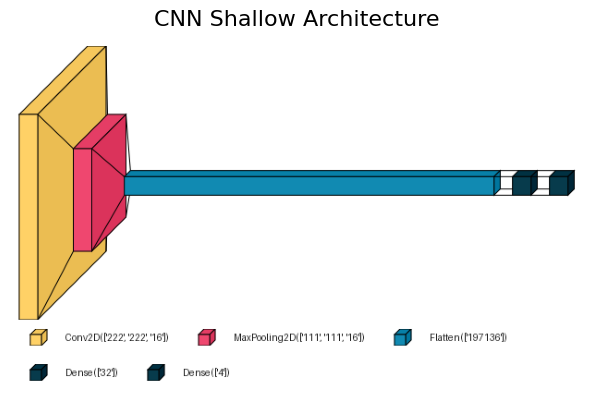

In [20]:
display_model_architecture(cnn_model_v1, model_name="CNN Shallow Architecture")

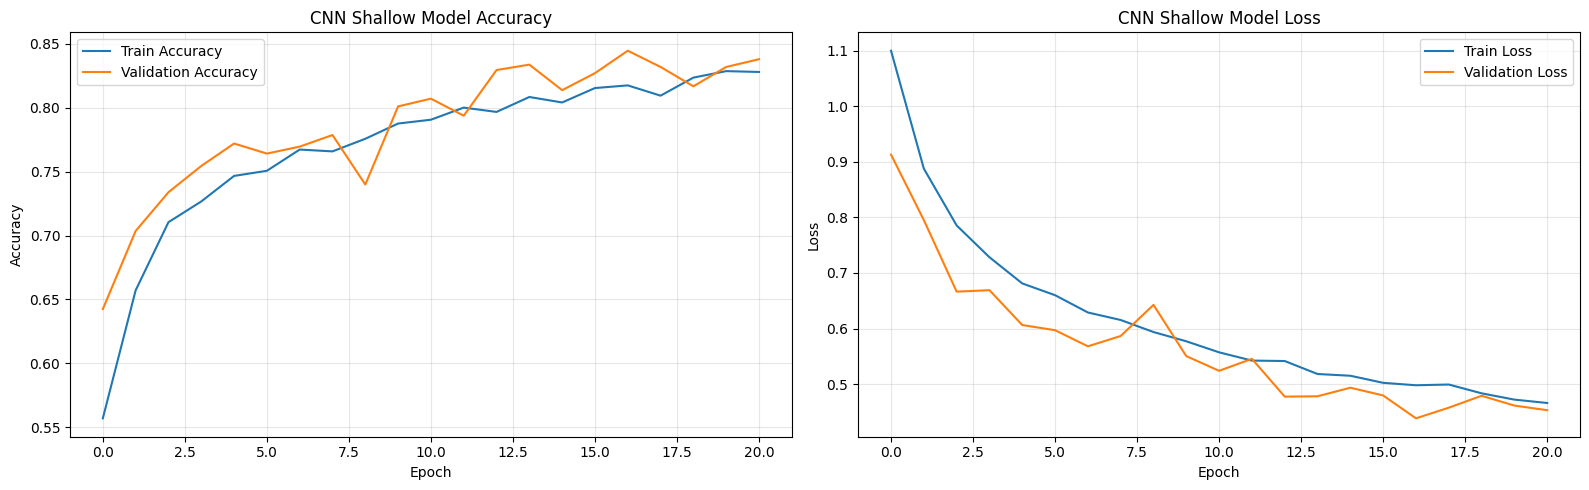

In [177]:
plot_training_history(history_v1, model_name="cnn_model_v1")

In [178]:
print_classification_report(cnn_model_v1, test_generator, class_names)

 2/52 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step 

/Users/DataAnalyst/Desktop/Machine Learning Class/venv_ML/lib/python3.12/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step
              precision    recall  f1-score   support

  meningioma       0.85      0.79      0.82       400
     healthy       0.88      0.95      0.92       695
      glioma       0.77      0.64      0.70       307
   pituitary       0.89      0.99      0.93       251

    accuracy                           0.86      1653
   macro avg       0.85      0.84      0.84      1653
weighted avg       0.85      0.86      0.85      1653



In [192]:
cnn_model_v1.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_11 (Conv2D)              │ (None, 222, 222, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 111, 111, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 197136)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 32)             │     6,308,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,926,030 (72.20 MB)

 Trainable params: 6,308,676 (24.07 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 12,617,354 (48.13 MB)

/Users/DataAnalyst/Desktop/Machine Learning Class/venv_ML/lib/python3.12/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step


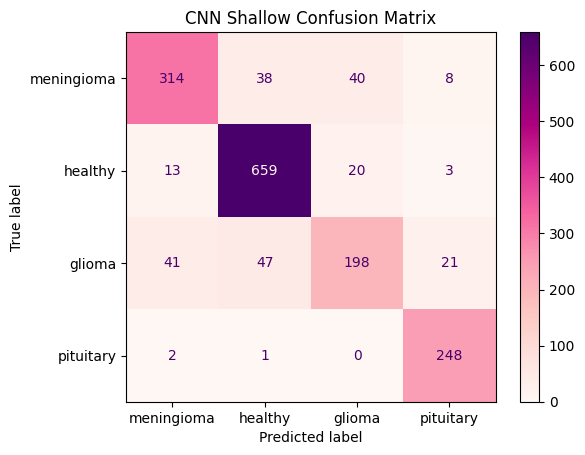

In [34]:
plot_confusion_matrix(cnn_model_v1, test_generator, class_names, model_name="CNN Shallow")

 2/52 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step 

/Users/DataAnalyst/Desktop/Machine Learning Class/venv_ML/lib/python3.12/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step


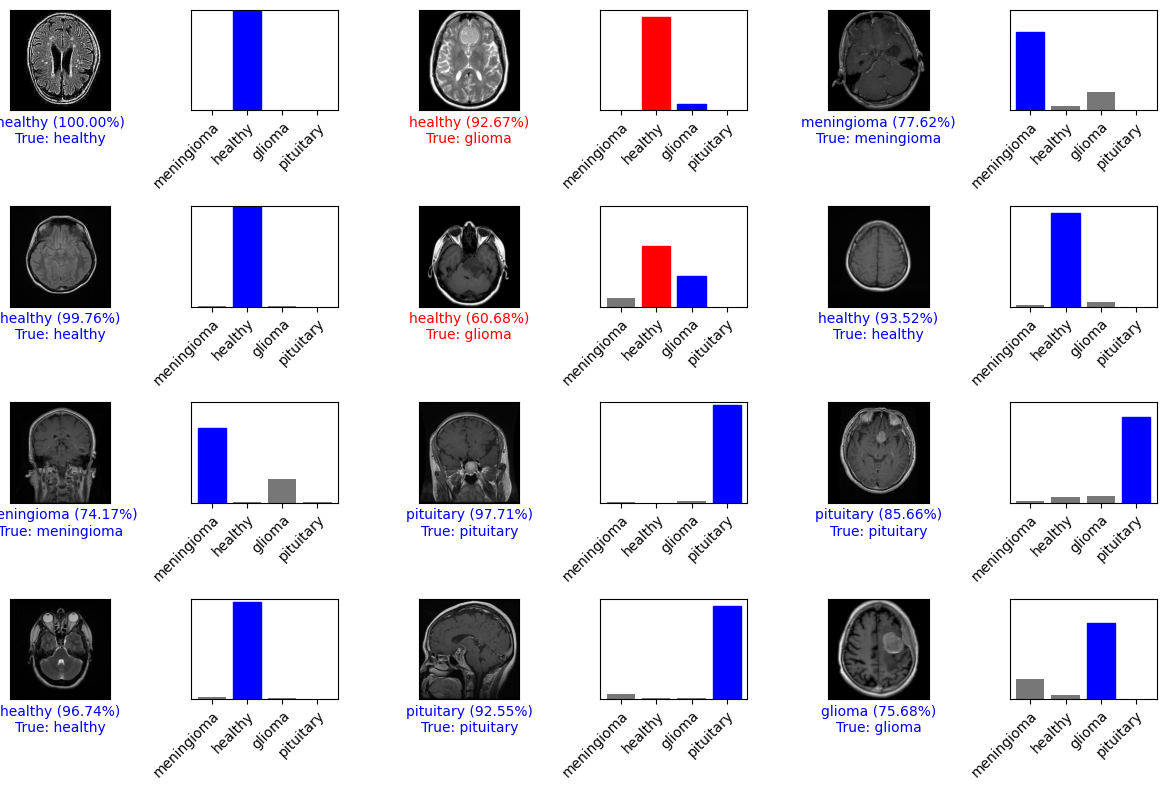

In [180]:
visualize_model_predictions(cnn_model_v1, class_names, test_generator)

## CNN Standard Results


Visualizing Layered Architecture:


/Users/DataAnalyst/Desktop/Machine Learning Class/venv_ML/lib/python3.12/site-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


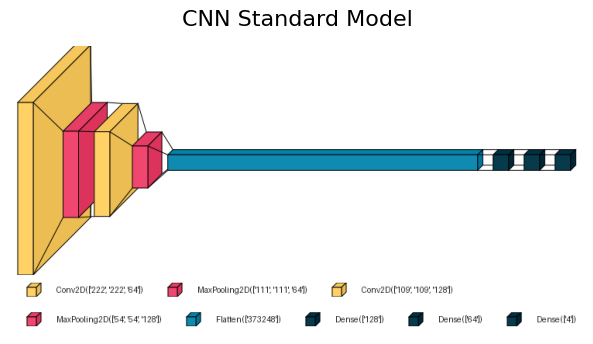

In [189]:
display_model_architecture(cnn_model_v2, model_name="CNN Standard Model")

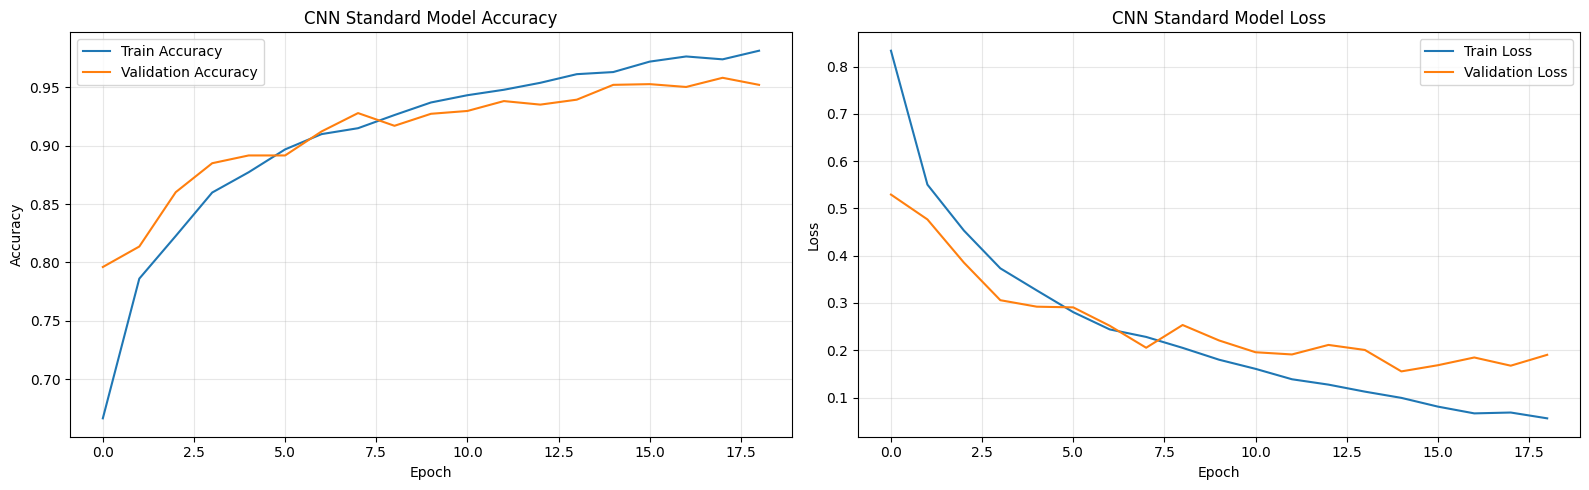

In [182]:
plot_training_history(history_v2, model_name="cnn_model_v2")

In [183]:
print_classification_report(cnn_model_v2, test_generator, class_names)

/Users/DataAnalyst/Desktop/Machine Learning Class/venv_ML/lib/python3.12/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


52/52 ━━━━━━━━━━━━━━━━━━━━ 22s 413ms/step
              precision    recall  f1-score   support

  meningioma       0.97      0.94      0.96       400
     healthy       0.98      0.98      0.98       695
      glioma       0.94      0.95      0.95       307
   pituitary       0.98      1.00      0.99       251

    accuracy                           0.97      1653
   macro avg       0.97      0.97      0.97      1653
weighted avg       0.97      0.97      0.97      1653



In [190]:
cnn_model_v2.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 222, 222, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 111, 111, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 109, 109, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 54, 54, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 373248)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │    47,775,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 143,576,654 (547.70 MB)

 Trainable params: 47,858,884 (182.57 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 95,717,770 (365.13 MB)

/Users/DataAnalyst/Desktop/Machine Learning Class/venv_ML/lib/python3.12/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


52/52 ━━━━━━━━━━━━━━━━━━━━ 50s 938ms/step


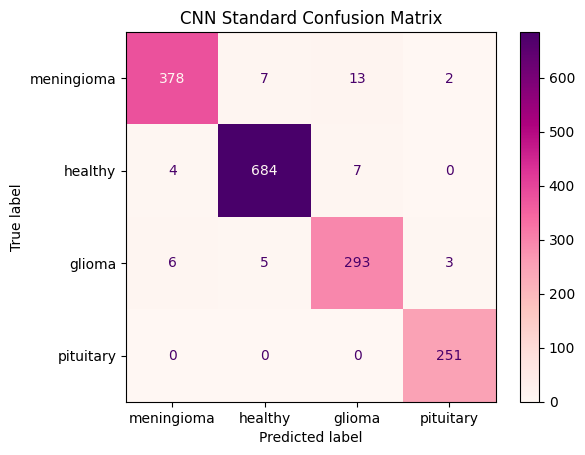

In [36]:
plot_confusion_matrix(cnn_model_v2, test_generator, class_names, model_name="CNN Standard")

/Users/DataAnalyst/Desktop/Machine Learning Class/venv_ML/lib/python3.12/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


52/52 ━━━━━━━━━━━━━━━━━━━━ 26s 487ms/step


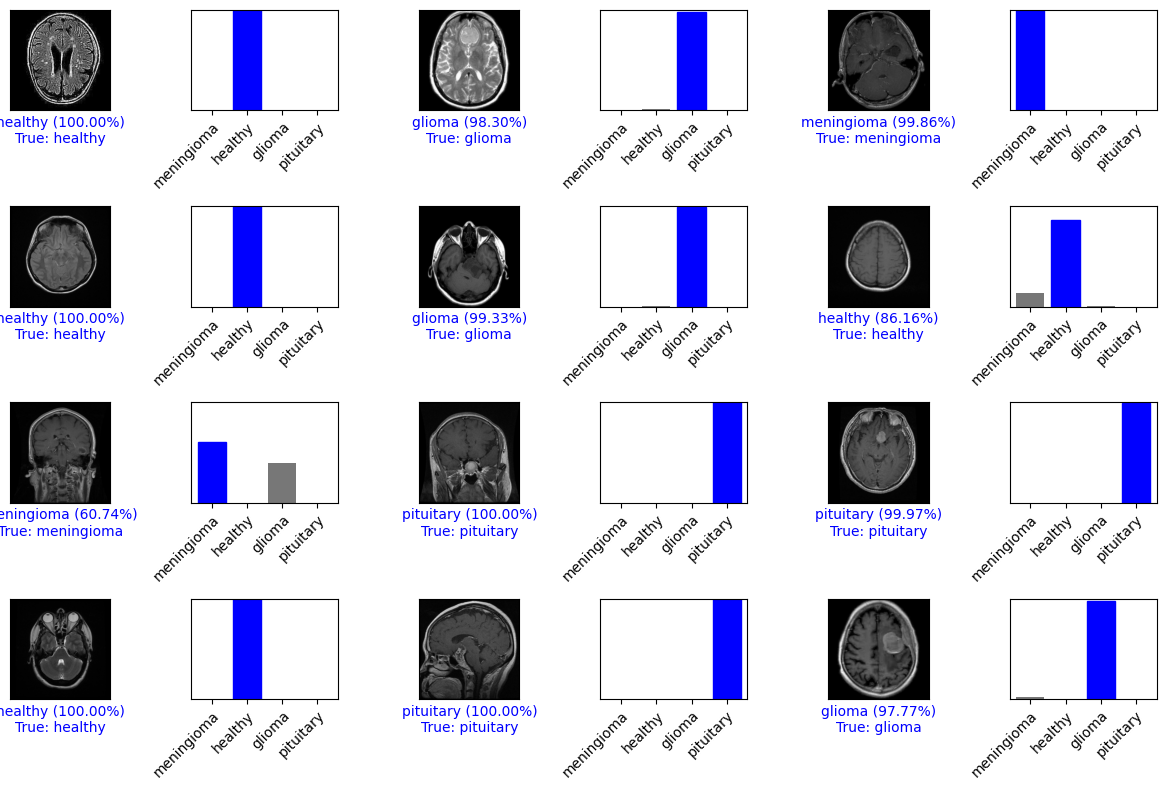

In [193]:
visualize_model_predictions(cnn_model_v2, class_names, test_generator)

## CNN Deep Results


Visualizing Layered Architecture:


/Users/DataAnalyst/Desktop/Machine Learning Class/venv_ML/lib/python3.12/site-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


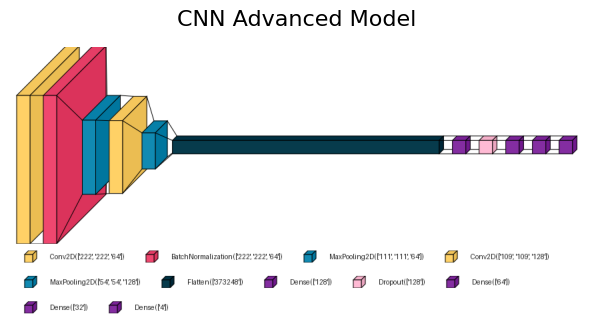

In [194]:
display_model_architecture(cnn_model_v3, model_name="CNN Advanced Model")

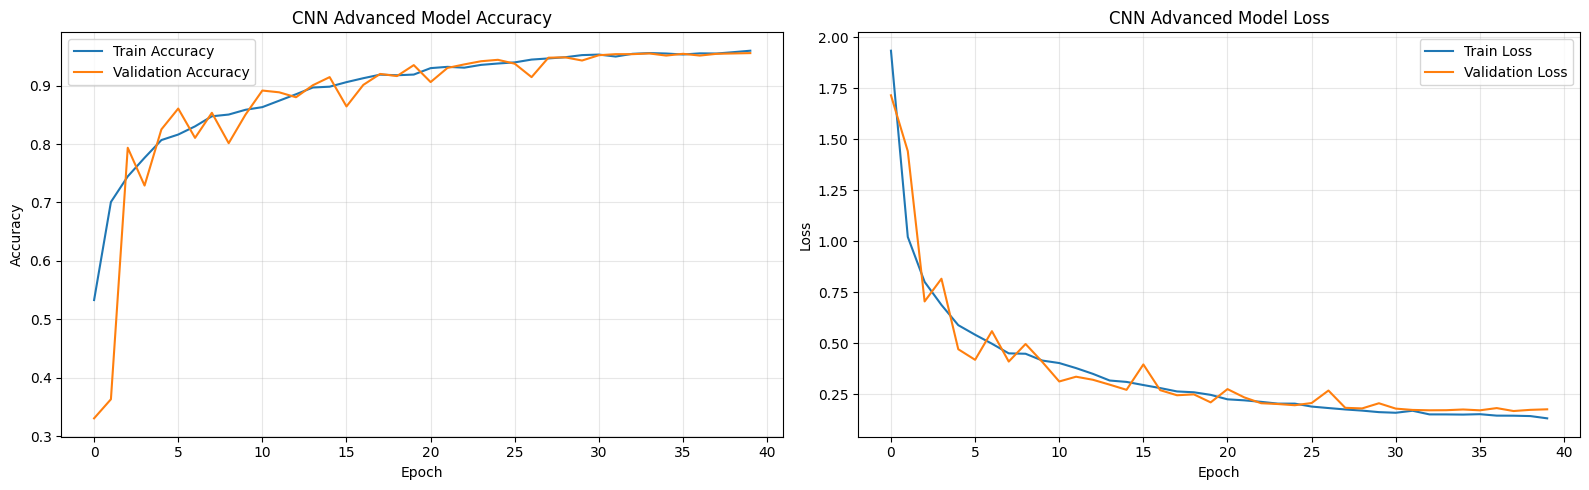

In [195]:
plot_training_history(history_v3, model_name="cnn_model_v3")

In [196]:
print_classification_report(cnn_model_v3, test_generator, class_names)

/Users/DataAnalyst/Desktop/Machine Learning Class/venv_ML/lib/python3.12/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


52/52 ━━━━━━━━━━━━━━━━━━━━ 44s 826ms/step
              precision    recall  f1-score   support

  meningioma       0.98      0.95      0.97       400
     healthy       0.99      0.99      0.99       695
      glioma       0.95      0.98      0.96       307
   pituitary       0.98      1.00      0.99       251

    accuracy                           0.98      1653
   macro avg       0.98      0.98      0.98      1653
weighted avg       0.98      0.98      0.98      1653



In [197]:
cnn_model_v3.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 222, 222, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 222, 222, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 111, 111, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 109, 109, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 54, 54, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 373248)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │    47,775,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 143,583,022 (547.73 MB)

 Trainable params: 47,860,964 (182.58 MB)

 Non-trainable params: 128 (512.00 B)

 Optimizer params: 95,721,930 (365.15 MB)

/Users/DataAnalyst/Desktop/Machine Learning Class/venv_ML/lib/python3.12/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


52/52 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step


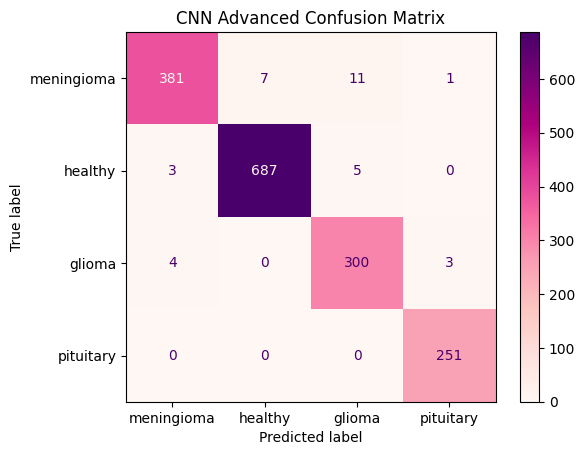

In [37]:
plot_confusion_matrix(cnn_model_v3, test_generator, class_names, model_name="CNN Advanced")

/Users/DataAnalyst/Desktop/Machine Learning Class/venv_ML/lib/python3.12/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


52/52 ━━━━━━━━━━━━━━━━━━━━ 42s 800ms/step


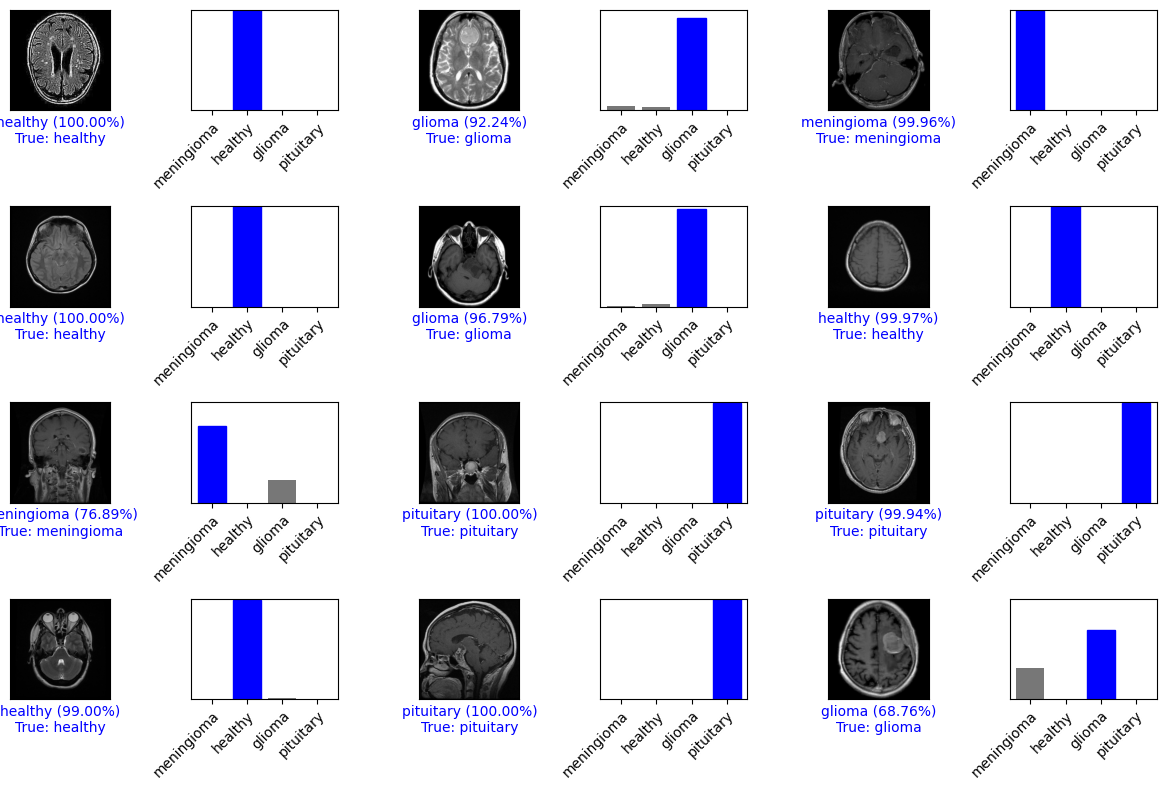

In [198]:
visualize_model_predictions(cnn_model_v3, class_names, test_generator)